### Instalación de dependencias.
Ejecutar solo una vez.

In [2]:
import os
from utils.requeriments import install_dependencies

install_dependencies()

🚀 Instalando PyTorch
• CUDA (driver) detectada: 12.8
• Python: 3.10.18
> c:\Users\i21316\.conda\envs\TRASH\python.exe -m pip uninstall -y torch torchvision torchaudio
➡️ Instalando build CUDA: cu128 (driver 12.8)
> c:\Users\i21316\.conda\envs\TRASH\python.exe -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
Torch: 2.8.0+cu128
torch.version.cuda: 12.8
CUDA disponible: True
GPUs detectadas: 1
GPU 0: NVIDIA RTX 6000 Ada Generation

📦 Instalando paquetes de requirements.txt…
> c:\Users\i21316\.conda\envs\TRASH\python.exe -m pip install -r requirements.txt
✅ Dependencias instaladas.
Resumen → CUDA driver: 12.8 | wheel: cu128


### Entrenamiento del modelo
Versiones de YOLOv11

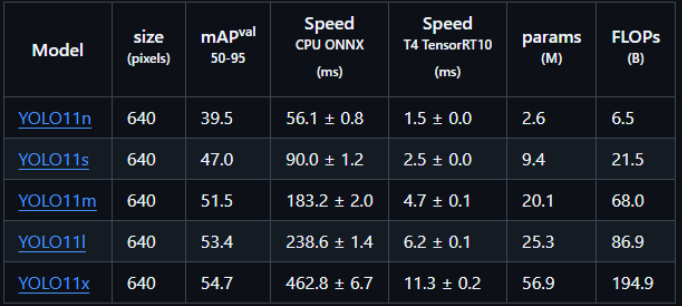

#### Variables de entrenamiento (Reinicio previo)

In [6]:
YOLO_MODEL = "yolo12"
YOLO_VERSION="x"

Descarga del dataset - Roboflow

In [4]:

# Cargar variables de entorno
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("ROBOFLOW_API_KEY")
if api_key is None:
    raise ValueError("ROBOFLOW_API_KEY environment variable not set")

from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("renzo-pgyz0").project("garbage-only-bags")
version = project.version(5)
dataset = version.download(YOLO_MODEL, location="data")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to data in yolov12:: 100%|██████████| 932/932 [00:01<00:00, 884.18it/s]


In [5]:
from utils.config import update_data_yalm_routes

# Sobrescribir el data.yaml original
update_data_yalm_routes("data/data.yaml")

✅ Rutas actualizadas en: data/data.yaml
📂 Nuevas rutas:
  train -> c:\Users\i21316\Downloads\TrashTraining\data\train\images
  val   -> c:\Users\i21316\Downloads\TrashTraining\data\valid\images
  test  -> c:\Users\i21316\Downloads\TrashTraining\data\test\images


In [ ]:
from ultralytics import YOLO
from datetime import datetime
import torch

yolo_model = YOLO_MODEL + YOLO_VERSION + ".pt"
model = YOLO(yolo_model)

project="projects"
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
name = f"{yolo_model.split('.')[0]}_{timestamp}"
print(f"🚀 Training {name}... 🚀")

torch.cuda.empty_cache()

results = model.train(
    project=project,
    name=name,
    data="data/data.yaml",
    epochs=300,                 # Aumentado para mayor convergencia con early stopping
    imgsz=960,                 # Buen equilibrio entre precisión y velocidad
    batch=8,                   # Puedes subirlo fácilmente con 48GB de VRAM
    lr0=0.001,                 # Más conservador para evitar saltos abruptos
    optimizer="AdamW",          # Bien para datasets pequeños
    weight_decay=0.01,          # Regularización más fuerte, ayuda contra overfitting
    amp=True,                   # Aprovechas mixed precision (esencial)
    cache="ram",               # Carga completo el dataset en RAM (tienes 256 GB)
    val=True,                   # Validación en cada época
    patience=50,                # Early stopping más tolerante por mayor número de épocas
    cos_lr=True,                # Scheduler suave, mantiene estabilidad
    warmup_epochs=5,           # Ayuda a evitar explosiones de gradiente
    device=0,                   # RTX 6000 será detectada como GPU 0
    seed=42,                    # Asegura replicabilidad
    deterministic=True          # Consistencia en resultados
)

🚀 Training yolo12x_20251011-1006... 🚀
Ultralytics 8.3.209  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA RTX 6000 Ada Generation, 49140MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo12x_20251011-1006, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mas

### Exportar modelos a formato TFLITE

In [ ]:
from utils.config import export_all_to_tflite

# Sobrescribir el data.yaml original
export_all_to_tflite()

### Probar TFLITE


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# 📌 Parámetros configurables
tflite_model_path = "exports/tflite_models/yolo12l_20250920-1944.tflite"  # <- Ajusta esta ruta
image_path = "data\\test\\images\\20240602_185949_jpg.rf.7d3e491593fe01bece08f204524e88d6.jpg"  # <- Reemplaza con tu imagen
input_size = 640
conf_threshold = 0.25

# 🖼️ Función para cargar imagen
def load_image(path, input_size):
    img = Image.open(path).convert("RGB").resize((input_size, input_size))
    img_np = np.array(img, dtype=np.float32) / 255.0  # Normaliza [0,1]
    return img, np.expand_dims(img_np, axis=0)

# 🧠 Cargar modelo
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 🔄 Inferencia
raw_img, input_data = load_image(image_path, input_size)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# 🧪 Post-procesamiento básico (sin NMS)
preds = output_data[0]  # Shape: [num_preds, 6] -> x, y, w, h, conf, class
print(f"🔎 Total de predicciones: {preds.shape[0]}")

# 🎯 Filtrar por confianza
filtered_preds = preds[preds[:, 4] > conf_threshold]
print(f"✅ Predicciones con conf > {conf_threshold}: {len(filtered_preds)}")

# 🖍️ Dibujar resultados
draw = ImageDraw.Draw(raw_img)
for pred in filtered_preds:
    x_center, y_center, w, h, conf, cls = pred
    x1 = (x_center - w / 2) * raw_img.width
    y1 = (y_center - h / 2) * raw_img.height
    x2 = (x_center + w / 2) * raw_img.width
    y2 = (y_center + h / 2) * raw_img.height
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    draw.text((x1, y1), f"{conf:.2f}", fill="yellow")

# 👁️ Mostrar imagen
plt.figure(figsize=(10, 10))
plt.imshow(raw_img)
plt.axis('off')
plt.title("Resultados TFLite")
plt.show()


In [ ]:
%pip install pandas matplotlib numpy

In [ ]:
# === Gráfico precisión vs latencia (estilo Ultralytics) ===
# - Usa mAP@0.5 proporcionados (completa los faltantes por interpolación/extrapolación).
# - Lee latencias p50 (ms/img) por modelo desde un CSV si está disponible.
# - Traza 3 curvas (YOLOv8, YOLOv11, YOLOv12) conectando tamaños n→x.
#
# Requisitos: matplotlib, numpy, pandas
# NOTA: Cambia CSV_PATH si tu archivo está en otra ruta o si quieres usar latencias propias.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
CSV_PATH = "latency_sim_15_models.csv"   # ruta a tu CSV con columnas: model,total_ms (1 fila por inferencia)
# Si no existe CSV_PATH, el script usará latencias de ejemplo (para que el gráfico corra igual).

# mAP@0.5 proporcionados por el usuario (faltantes = None; el script los completará)
MAP_8 = {"n": 0.799, "s": 0.826, "m": 0.756, "l": 0.753, "x": 0.773}
MAP_11 = {"n": 0.846, "s": 0.799, "m": 0.794, "l": 0.764,   "x": 0.743}
MAP_12 = {"n": 0.777, "s": 0.803,   "m": 0.80,   "l": 0.784, "x": 0.736}

# ---------- UTILIDADES ----------
sizes = ["n", "s", "m", "l", "x"]
size_idx = {s: i for i, s in enumerate(sizes)}

def complete_family_map(fam_map):
    """Completa mAP faltantes por modelo (n,s,m,l,x) usando ajuste polinómico:
       - Si hay >=3 puntos: grado 2 (cuadrático).
       - Si hay 2 puntos: grado 1 (lineal).
       - Si hay 1 punto: constante.
       Devuelve un dict con todos los tamaños completos.
    """
    xs_known = []
    ys_known = []
    for s in sizes:
        v = fam_map.get(s, None)
        if v is not None:
            xs_known.append(size_idx[s])
            ys_known.append(float(v))

    # Selección de grado
    if len(xs_known) >= 3:
        deg = 2
    elif len(xs_known) == 2:
        deg = 1
    else:
        deg = 0  # constante

    # Ajuste
    coeffs = np.polyfit(xs_known, ys_known, deg)
    poly = np.poly1d(coeffs)

    # Completa faltantes y arma dict final (clamp a [0,1] por seguridad)
    out = {}
    for s in sizes:
        val = fam_map.get(s, None)
        if val is None:
            pred = float(poly(size_idx[s]))
            pred = max(0.0, min(1.0, pred))
            out[s] = pred
        else:
            out[s] = float(val)
    return out

# Completar mAP faltantes
MAP_11 = complete_family_map(MAP_11)
MAP_12 = complete_family_map(MAP_12)

# Empaquetar mAP por modelo
MAP_BY_MODEL = {
    **{f"yolo8{k}": v for k, v in MAP_8.items()},
    **{f"yolo11{k}": v for k, v in MAP_11.items()},
    **{f"yolo12{k}": v for k, v in MAP_12.items()},
}

# ---------- LATENCIAS ----------
# Esperamos un CSV con filas por inferencia y columnas:
# model,total_ms (puede tener además pre_ms,infer_ms,post_ms,imgsz,conf,iou,width,...)
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    assert {"model", "total_ms"}.issubset(df.columns), \
        "El CSV debe contener columnas 'model' y 'total_ms'."
    lat_p50 = df.groupby("model")["total_ms"].median().to_dict()
else:
    # Latencias de ejemplo (ms/img) para que el gráfico sea reproducible si no hay CSV
    lat_p50 = {
        "yolo8n": 120, "yolo8s": 180, "yolo8m": 300, "yolo8l": 520, "yolo8x": 850,
        "yolo11n": 110, "yolo11s": 170, "yolo11m": 280, "yolo11l": 500, "yolo11x": 820,
        "yolo12n": 105, "yolo12s": 165, "yolo12m": 270, "yolo12l": 480, "yolo12x": 800,
    }

# ---------- PREPARACIÓN DE SERIES ----------
families = [("YOLOv8", "yolo8"), ("YOLOv11", "yolo11"), ("YOLOv12", "yolo12")]

series = {}
for fam_name, fam_key in families:
    pts = []
    for s in sizes:
        model = f"{fam_key}{s}"
        if model in MAP_BY_MODEL and model in lat_p50:
            pts.append((float(lat_p50[model]), float(MAP_BY_MODEL[model]), f"{fam_key.replace('yolo','')}{s}"))
    # ordenar por latencia para unir n→x correctamente
    pts.sort(key=lambda t: t[0])
    if pts:
        series[fam_name] = pts

# ---------- GRÁFICO ----------
fig, ax = plt.subplots(figsize=(9.5, 4.8), dpi=150)

for fam_name, pts in series.items():
    xs = [p[0] for p in pts]  # latencia ms/img
    ys = [p[1] for p in pts]  # mAP@0.5
    ax.plot(xs, ys, marker="o", linewidth=2.0, label=fam_name)
    # Anotar cada punto (8n, 11m, 12x, etc.)
    for (x, y, lbl) in pts:
        ax.annotate(lbl, (x, y), textcoords="offset points", xytext=(5, 6), fontsize=9)

ax.set_xlabel("Latencia p50 (ms/imagen)", fontsize=11)
ax.set_ylabel("mAP@0.5", fontsize=11)
ax.grid(True, which="both", linestyle="--", alpha=0.25)
ax.legend(loc="lower right", fontsize=9)

# Límites cómodos
if series:
    all_x = [p[0] for pts in series.values() for p in pts]
    all_y = [p[1] for pts in series.values() for p in pts]
    ax.set_xlim(left=0, right=max(all_x) * 1.1)
    ymin = min(all_y) if len(all_y) else 0.5
    ymax = max(all_y) if len(all_y) else 0.9
    margin = max(0.01, (ymax - ymin) * 0.05)
    ax.set_ylim(bottom=max(0.0, ymin - margin), top=min(1.0, ymax + margin))

plt.tight_layout()
plt.show()

# ---------- (Opcional) imprimir los mAP completados ----------
print("mAP@0.5 completados:")
print("YOLOv8 :", MAP_8)
print("YOLOv11:", MAP_11)
print("YOLOv12:", MAP_12)
